In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

### Pitching Data  
After considerable manipulation in Excel.  

The values in these fields are points earned by positioning at the top of league leaderboards for the year.  For fairness for recent players, the scope of leadership is expanded as the number of teams expand, though points given always range from 10 - 0.

In [2]:
pitching_df = pd.read_csv("db/pitching_phase3.csv")
pitching_df.fillna(value=0,inplace=True)

# after further consideration, I am eliminating Complete Games and Shutouts here.  These have become relatively rare.
del pitching_df["CG"]
del pitching_df["SHO"]

pitching_df.head()

,playerID,W,G,GS,SV,IPouts,SO,ERA,WLpct,W_IP,H_IP
0,aardsda01,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,0.0,6.470588,0.0,8.235294,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,0.0,0.000000,0.0,6.470588,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Summarize the pitching data into player data
pitching_df = pitching_df.groupby(["playerID"],as_index=False).sum()
pitching_df.head(10)

,playerID,W,G,GS,SV,IPouts,SO,ERA,WLpct,W_IP,H_IP
0,aardsda01,0.000000,6.470588,0.000000,14.705882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,aasedo01,0.000000,10.588235,0.000000,21.176471,0.000000,0.000000,0.000000,4.705882,7.058824,0.000000
2,abadfe01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,abbotgl01,0.000000,0.000000,3.529412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,abbotji01,8.235294,0.000000,19.411765,0.000000,11.176471,5.294118,21.176471,4.705882,18.235294,1.764706
5,abbotky01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,abbotpa01,7.058824,0.000000,0.000000,0.000000,0.000000,0.000000,4.117647,9.411765,0.000000,13.529412
7,aberal01,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,abernbi01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,abernte01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Experiment:
What if we eliminate zero-value players here instead of below?

In [4]:
# pitching_df["totalPts"] = (pitching_df["W"] + pitching_df["SV"] 
#                                 + pitching_df["SO"] + pitching_df["ERA"]  )

#pitching_df = pitching_df.loc[pitching_df["totalPts"] > 0, :]            

# Answer: we reduce the R2 value slightly to .9797
# Tim Hudson drops off the predicted list but so does Roy Halladay, for what I expect to be a net-zero change
            

At this point, introduce data to identify players as being in the Hall Of Fame or not

In [5]:
HOF_df = pd.read_csv("db/HallOfFame.csv")
HOF_df.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN


In [6]:
# unsuccessful votes are irrelevant for our purposes
HOF_subset1_df = HOF_df.loc[HOF_df["inducted"] == "Y", :]

# consider only those elected as players.  Some players were elected as managers.
HOF_subset2_df = HOF_subset1_df.loc[HOF_subset1_df["category"] == "Player", :]

# exclude any players elected from the Negro Leagues.  These are not likely to have relevant MLB statistics
HOF_subset3_df = HOF_subset2_df.loc[HOF_subset2_df["votedBy"] != "Negro League", :]


# discard unneeded columns
xyz = ["playerID","inducted"]
HOF_df = HOF_subset3_df[xyz]
HOF_df.head()

,playerID,inducted
0,cobbty01,Y
1,ruthba01,Y
2,wagneho01,Y
3,mathech01,Y
4,johnswa01,Y


In [7]:
# And Still,  Babe Ruth is not in the Hall Of Fame because of his pitching
pitching_df = pitching_df.loc[pitching_df["playerID"] != "ruthba01", :]

In [8]:
pitching2_df = pd.merge(pitching_df, HOF_df, on="playerID", how="left")

We will need to convert the "inducted" to 1s and 0s

In [9]:
pitching2_df["HOF_member"] = np.where(pitching2_df["inducted"] == "Y",1,0)
pitching2_df.head(15)

,playerID,W,G,GS,SV,IPouts,SO,ERA,WLpct,W_IP,H_IP,inducted,HOF_member
0,aardsda01,0.000000,6.470588,0.000000,14.705882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
1,aasedo01,0.000000,10.588235,0.000000,21.176471,0.000000,0.000000,0.000000,4.705882,7.058824,0.000000,NaN,0
2,abadfe01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
3,abbotgl01,0.000000,0.000000,3.529412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
4,abbotji01,8.235294,0.000000,19.411765,0.000000,11.176471,5.294118,21.176471,4.705882,18.235294,1.764706,NaN,0
5,abbotky01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
6,abbotpa01,7.058824,0.000000,0.000000,0.000000,0.000000,0.000000,4.117647,9.411765,0.000000,13.529412,NaN,0
7,aberal01,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
8,abernbi01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
9,abernte01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0


In [10]:
years_df = pd.read_csv("db/pitchers_years.csv")

In [11]:
pitching2_df = pd.merge(pitching2_df, years_df, on="playerID", how="left")
pitching2_df.head()

,playerID,W,G,GS,SV,IPouts,SO,ERA,WLpct,W_IP,H_IP,inducted,HOF_member,last year,decade
0,aardsda01,0.000000,6.470588,0.000000,14.705882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,2015,2000
1,aasedo01,0.000000,10.588235,0.000000,21.176471,0.000000,0.000000,0.000000,4.705882,7.058824,0.000000,NaN,0,1990,1980
2,abadfe01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,2017,2010
3,abbotgl01,0.000000,0.000000,3.529412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,1984,1970
4,abbotji01,8.235294,0.000000,19.411765,0.000000,11.176471,5.294118,21.176471,4.705882,18.235294,1.764706,NaN,0,1999,1990


considering only pitchers from the 20s on

In [12]:
pitching2_df = pitching2_df.loc[pitching2_df["decade"] > 1910, :]

------
Next will be to split off more recent players.  These are still active and recent retirees, and can be used to make and test predictions.

In [13]:
pitching_recent_df = pitching2_df.loc[pitching2_df["last year"] > 2010, :]
pitching4_df       = pitching2_df.loc[pitching2_df["last year"] < 2011, :]

At this point, the data is ready to be processed into a logistic regression.  Drop lastyear. 

In [14]:
del pitching_recent_df["last year"]
del pitching4_df["last year"]
del pitching_recent_df["decade"]
del pitching4_df["decade"]
del pitching_recent_df["inducted"]
del pitching4_df["inducted"]

In [15]:
pitching4_df.columns

Index(['playerID', 'W', 'G', 'GS', 'SV', 'IPouts', 'SO', 'ERA', 'WLpct',
       'W_IP', 'H_IP', 'HOF_member'],
      dtype='object')

In [16]:
# fieldlist = ['W', 'G', 'GS', 'SV', 'IPouts', 'SO', 'ERA', 'WLpct', 'W_IP', 'H_IP']
# coefficients for the above are:  .45, -.01, .08, .65, .08, .25, .34, .09, -.05, -.02 respectively.
# so to avoid overfitting, we will reduce down to the below:

fieldlist = ['W', 'SV', 'SO', 'ERA']
X = pitching4_df[fieldlist]
y = pitching4_df["HOF_member"]

In [17]:
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=26)

In [18]:
# Normalize the data.  Here, we are using StandardScaler
X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
model = LogisticRegression(C=1.0, penalty='l2', random_state=27, solver="saga", max_iter=5000)

In [20]:
model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test_scaled, y_test)

print(f"MSE: {MSE}, R2: {r2}") 

MSE: 0.008213552361396304, R2: 0.9917864476386037


In [22]:
X_test.head()

,W,SV,SO,ERA
6927,0.0,0.0,0.0,0.0
5306,0.0,0.0,0.0,0.0
8335,0.0,0.0,0.0,0.0
3161,0.0,0.0,0.0,0.0
5656,0.0,0.0,0.0,0.0


In [23]:
model.coef_

array([[0.61687098, 0.65392536, 0.24444348, 0.35773952]])

Here's what we've been waiting for:  Let's make Hall-Of-Fame predictions for more recent and current players.

In [24]:
recent_players = pitching_recent_df["playerID"]
X_recent = pitching_recent_df[fieldlist]


In [25]:
X_recent_scaled = X_scaler.transform(X_recent)

In [26]:
predictions_recent = model.predict(X_recent_scaled)

In [27]:
X_recent["predictions"] = predictions_recent
X_recent["playerID"] = recent_players

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
people_df = pd.read_csv("db/people.csv")

players_df = people_df[["playerID","nameFirst","nameLast"]]
players_df["nameFull"] = players_df["nameFirst"]+' '+players_df["nameLast"]
players_df.head()

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,playerID,nameFirst,nameLast,nameFull
0,aardsda01,David,Aardsma,David Aardsma
1,aaronha01,Hank,Aaron,Hank Aaron
2,aaronto01,Tommie,Aaron,Tommie Aaron
3,aasedo01,Don,Aase,Don Aase
4,abadan01,Andy,Abad,Andy Abad


In [29]:
Predicted_for_HOF = X_recent.loc[X_recent["predictions"] == 1, :]
#Predicted_for_HOF = X_recent
Predicted_for_HOF = pd.merge(Predicted_for_HOF, players_df, on="playerID", how="left")
del Predicted_for_HOF["nameFirst"]
del Predicted_for_HOF["nameLast"]
display(Predicted_for_HOF)

,W,SV,SO,ERA,predictions,playerID,nameFull
0,57.058824,0.00000,50.852941,63.205882,1,hallaro01,Roy Halladay
1,66.147059,0.00000,24.117647,62.058824,1,hudsoti01,Tim Hudson
2,0.000000,132.47678,0.000000,0.000000,1,riverma01,Mariano Rivera
3,68.575851,0.00000,63.281734,49.814241,1,sabatcc01,CC Sabathia
4,67.027864,0.00000,76.688854,50.619195,1,scherma01,Max Scherzer
5,81.238390,0.00000,83.374613,68.018576,1,verlaju01,Justin Verlander


In [30]:
Predicted_for_HOF = pd.merge(X_recent, players_df, on="playerID", how="left")

Predicted_for_HOF["totalPts"] = (Predicted_for_HOF["W"] + Predicted_for_HOF["SV"] 
                                 + Predicted_for_HOF["SO"] + Predicted_for_HOF["ERA"]  )

Predicted_for_HOF = Predicted_for_HOF.loc[Predicted_for_HOF["totalPts"] > 0, :]            
            
xyz = ["playerID", "predictions"]
pitcher_stats_df = Predicted_for_HOF[xyz]

del Predicted_for_HOF["totalPts"]
del Predicted_for_HOF["nameFirst"]
del Predicted_for_HOF["nameLast"]
del Predicted_for_HOF["playerID"]
Predicted_for_HOF.to_csv("pitching picks.csv", index=False, header=True)

Prepare data so we can make a chart similar to that of batters

In [31]:
pitching_df = pd.read_csv("db/Pitching.csv")
pitcher_stats_df = pd.merge(pitching_df, pitcher_stats_df, on="playerID", how="inner")
pitcher_stats_df.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'predictions'],
      dtype='object')

In [32]:
del pitcher_stats_df["yearID"]
del pitcher_stats_df["stint"]
del pitcher_stats_df["teamID"]
del pitcher_stats_df["lgID"]
del pitcher_stats_df["L"]
del pitcher_stats_df["G"]
del pitcher_stats_df["CG"]
del pitcher_stats_df["SHO"]
del pitcher_stats_df["SV"]
del pitcher_stats_df["HR"]
del pitcher_stats_df["BAOpp"]
del pitcher_stats_df["WP"]
del pitcher_stats_df["HBP"]
del pitcher_stats_df["BK"]
del pitcher_stats_df["BFP"]
del pitcher_stats_df["GF"]
del pitcher_stats_df["R"]
del pitcher_stats_df["SH"]
del pitcher_stats_df["SF"]
del pitcher_stats_df["GIDP"]
pitcher_stats_df.head()

,playerID,W,GS,IPouts,H,ER,BB,SO,ERA,IBB,predictions
0,moyerja01,7,16,262,107,49,42,45,5.05,1.0,0
1,moyerja01,12,33,603,210,114,97,147,5.10,9.0,0
2,moyerja01,9,30,606,212,78,55,121,3.48,7.0,0
3,moyerja01,4,15,228,84,41,33,44,4.86,0.0,0
4,moyerja01,2,10,307,115,53,39,58,4.66,4.0,0


In [33]:
X_graph_grouped = pitcher_stats_df.groupby(["predictions"],as_index=False).mean()

X_graph_grouped["ERA"] =  (
                            9 * X_graph_grouped["ER"] 
                            / (X_graph_grouped["IPouts"] / 3)
                           )
X_graph_grouped["WHIP"] = (
                            (X_graph_grouped["H"] + X_graph_grouped["BB"] - X_graph_grouped["IBB"])
                            / (X_graph_grouped["IPouts"] / 3)
                           )


X_graph_grouped

,predictions,W,GS,IPouts,H,ER,BB,SO,ERA,IBB,WHIP
0,0,5.722433,12.572481,283.333175,90.910171,41.405418,31.688688,79.415399,3.945695,1.891873,1.278075
1,1,11.505155,22.319588,479.577320,144.639175,59.628866,43.793814,139.288660,3.357080,2.484536,1.163202


In [34]:
# Need to rescale the averages so they don't get swamped by the counting stats
X_graph_grouped["ERA"] = X_graph_grouped["ERA"] * 10
X_graph_grouped["WHIP"] = X_graph_grouped["WHIP"] * 10

In [35]:
# Innings Pitched is more standard than IPouts
X_graph_grouped["IP"] = X_graph_grouped["IPouts"] / 3
X_graph_grouped

,predictions,W,GS,IPouts,H,ER,BB,SO,ERA,IBB,WHIP,IP
0,0,5.722433,12.572481,283.333175,90.910171,41.405418,31.688688,79.415399,39.456950,1.891873,12.780747,94.444392
1,1,11.505155,22.319588,479.577320,144.639175,59.628866,43.793814,139.288660,33.570799,2.484536,11.632021,159.859107


In [36]:
n_groups = 6
means_no  = X_graph_grouped.iloc[0, [1,2,11,7,8,10]]
means_yes = X_graph_grouped.iloc[1, [1,2,11,7,8,10]]

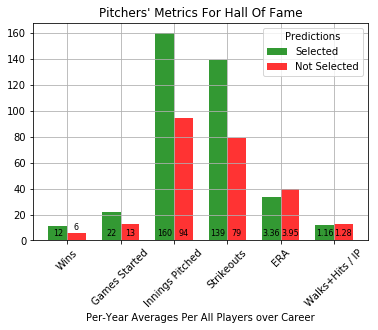

In [37]:
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_yes, bar_width,
alpha=opacity,
color='g',
label='Selected')

rects2 = plt.bar(index + bar_width, means_no, bar_width,
alpha=opacity,
color='r',
label='Not Selected')

plt.xlabel('Per-Year Averages Per All Players over Career')
plt.title("Pitchers' Metrics For Hall Of Fame")
plt.xticks(index + (bar_width/2), ('Wins', 'Games Started', 'Innings Pitched', 'Strikeouts', 
                                   'ERA', 'Walks+Hits / IP' ), rotation=45)
plt.grid()
plt.legend(title="Predictions")

# Use functions to label the percentages of changes
def valuelabel(rects, ptext):

    x = 0
    for rect in rects:
        height = rect.get_height()
        if height > 10:
            ypos = 2
        elif height > 0:
            ypos = height + 1   # not enough room in the bar, so display just over it
        elif height > -10:
            ypos = height - 5
        else:
            ypos = -6
            
        plt.text(rect.get_x() + rect.get_width() / 2, ypos, ptext[x], ha="center", va="bottom", fontsize=8)
        x += 1
 
# reverse the above rescaling so that we can show true values
means_yes[4] = means_yes[4] / 10
means_yes[5] = means_yes[5] / 10

# Call function to implement value labeling
chgx = pd.Series(["{:.0f}".format(means_yes[0]),
                  "{:.0f}".format(means_yes[1]),
                  "{:.0f}".format(means_yes[2]),
                  "{:.0f}".format(means_yes[3]),
                  "{:.2f}".format(means_yes[4]),
                  "{:.2f}".format(means_yes[5])
                 ])
valuelabel(rects1, chgx)






means_no[4] = means_no[4] / 10
means_no[5] = means_no[5] / 10

chgx = pd.Series(["{:.0f}".format(means_no[0]),
                  "{:.0f}".format(means_no[1]),
                  "{:.0f}".format(means_no[2]),
                  "{:.0f}".format(means_no[3]),
                  "{:.2f}".format(means_no[4]),
                  "{:.2f}".format(means_no[5])
                 ])

valuelabel(rects2, chgx)    

# Save the Figure
plt.savefig("pitchers_metrics.png", bbox_inches="tight")